In [1]:
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import phate

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt

import sys
sys.path.append("../../lib")
from stpalette import palette1
from plots import simpleCorrPlot
from plots import plotSpatialAll
from utils import swapLabels

In [2]:
model = 'WM4007'

In [3]:
preprocessedStDataPath = 'c:/Projects/A_ST/from HPCC 11 28 2022/results_NF1-nod-t2t-k35/%s/' % model
dataPath = '../../data/'

ids = sorted(np.loadtxt(dataPath + 'ids_%s_ST.txt' % model, dtype=str))
ids

['WM4007_T0_S1_ST',
 'WM4007_T0_S2_ST',
 'WM4007_T1_S1_ST',
 'WM4007_T1_S2_ST',
 'WM4007_T2_S1_ST',
 'WM4007_T2_S2_ST',
 'WM4007_T3_S1_ST',
 'WM4007_T3_S2_ST',
 'WM4007_T4_S1_ST',
 'WM4007_T4_S2_ST',
 'WM4007_TC_S1_ST',
 'WM4007_TC_S2_ST']

In [4]:
palette1.update({id: cm.terrain(0.01 + i/len(ids)) for i, id in enumerate(ids)})

In [36]:
ad_all = sc.read(dataPath + 'ad_all_scaled_filtered_st_%s.h5ad' % model)
ad_all.shape

(11990, 17788)

# PCA and batch correction

In [37]:
sc.pp.highly_variable_genes(ad_all, flavor='seurat', batch_key='sample', n_top_genes=2500)

C:\Users\domans\Anaconda3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
C:\Users\domans\Anaconda3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
C:\Users\domans\Anaconda3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
C:\Users\domans\Anaconda3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be

In [38]:
sc.pp.pca(ad_all, n_comps=50, zero_center=True, use_highly_variable=True)
sce.pp.harmony_integrate(ad_all, 'sample', lamb=0.5)
sc.pp.neighbors(ad_all, use_rep='X_pca_harmony')
sc.tl.umap(ad_all)

2022-12-05 13:08:28,902 - harmonypy - INFO - Iteration 1 of 10
2022-12-05 13:08:33,925 - harmonypy - INFO - Iteration 2 of 10
2022-12-05 13:08:38,913 - harmonypy - INFO - Iteration 3 of 10
2022-12-05 13:08:43,709 - harmonypy - INFO - Converged after 3 iterations


In [39]:
print('Clustering')
for res in [0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 1.0]:
    sc.tl.leiden(ad_all, key_added='all_clusters_%s' % res, resolution=res)

Clustering


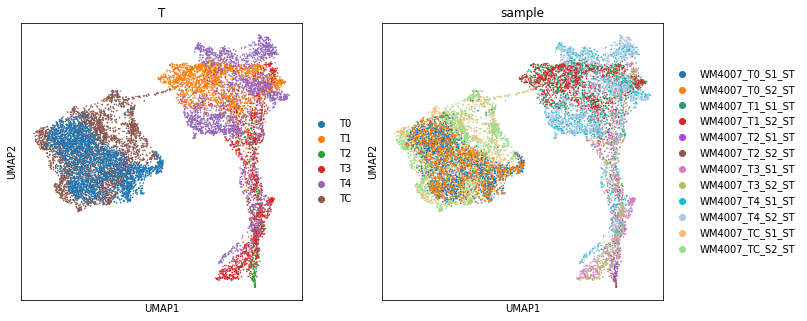

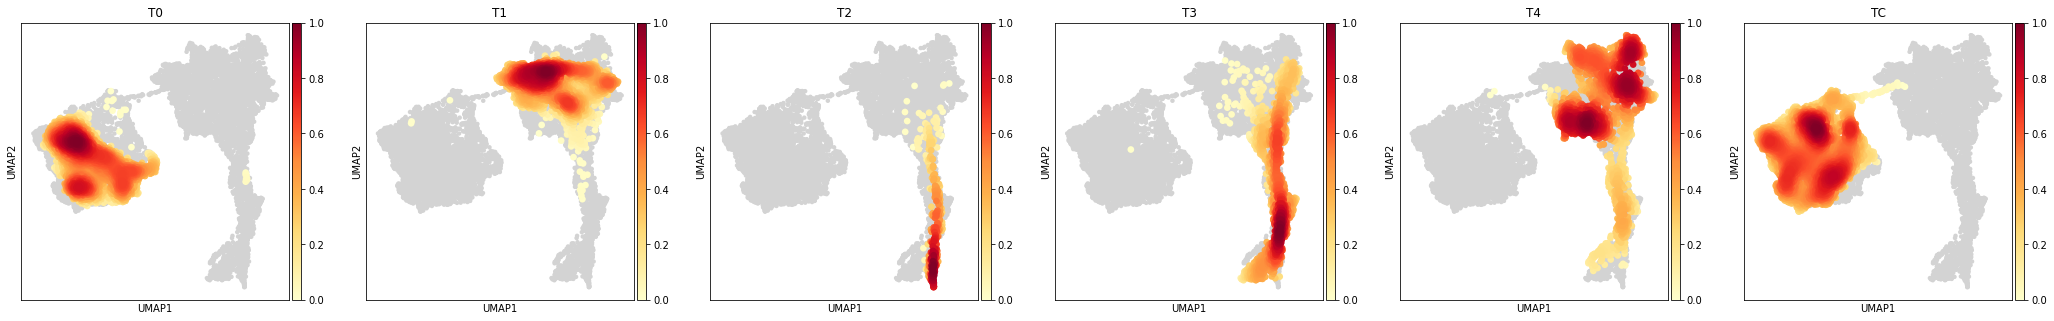

In [43]:
sc.pl.umap(ad_all, color=['T', 'sample'])
plt.rcParams["figure.figsize"] = (5,5)
identity = 'T'
sc.tl.embedding_density(ad_all, basis='umap', groupby=identity)
sc.pl.embedding_density(ad_all, groupby=identity, ncols=10)

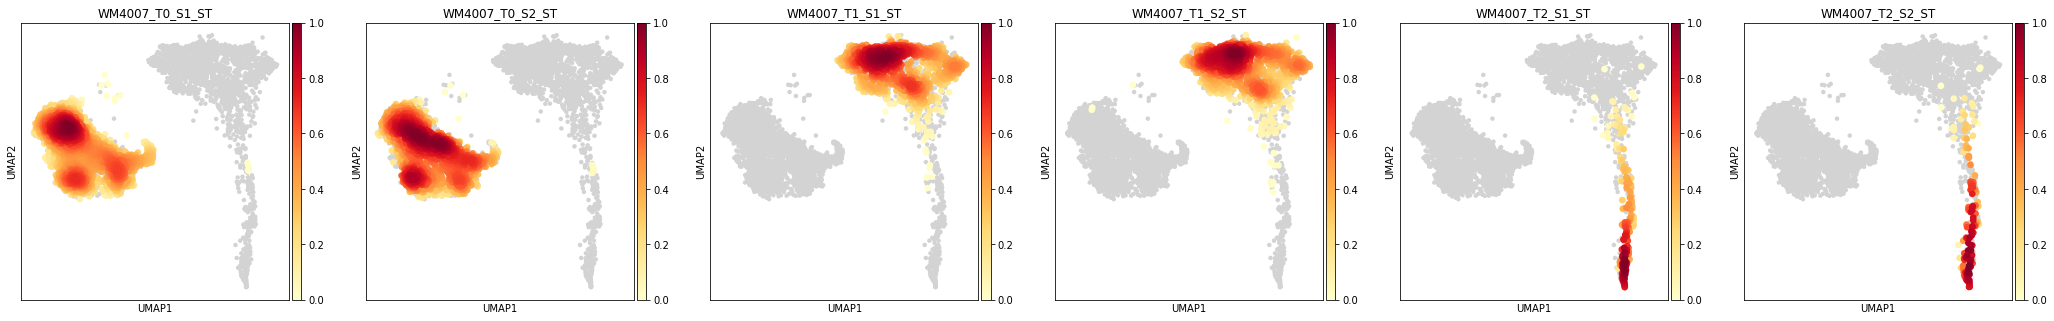

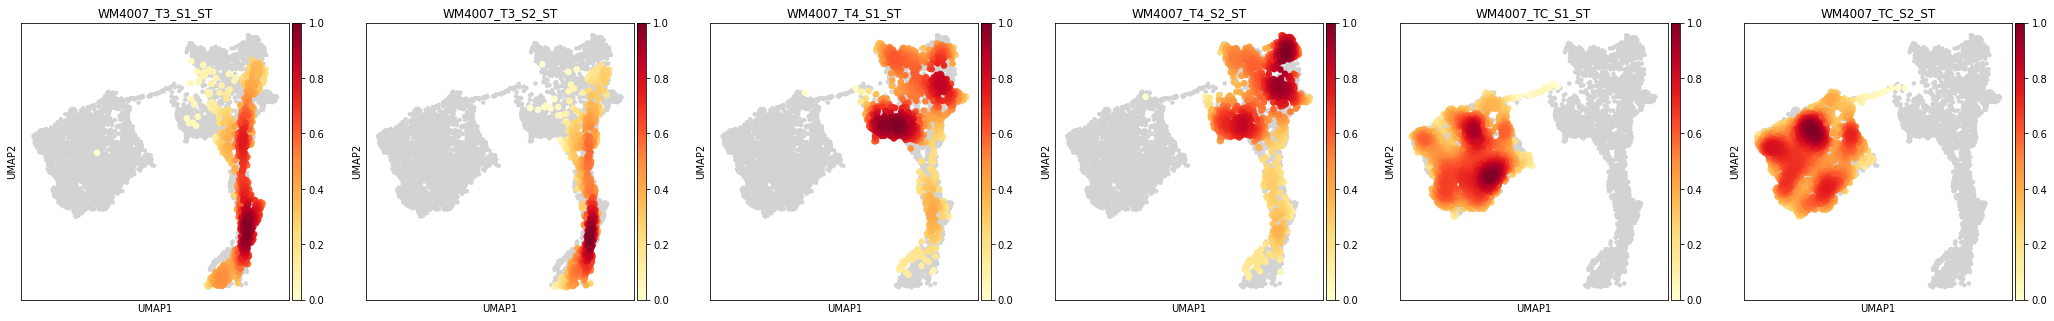

In [44]:
split = 6

identity = 'sample'
ad_part = ad_all[ad_all.obs[identity].isin(ids[:split]), :].copy()
ad_part.X = None
sc.tl.embedding_density(ad_part, basis='umap', groupby=identity)
sc.pl.embedding_density(ad_part, groupby=identity, ncols=split)
ad_part = ad_all[ad_all.obs[identity].isin(ids[split:]), :].copy()
ad_part.X = None
sc.tl.embedding_density(ad_part, basis='umap', groupby=identity)
sc.pl.embedding_density(ad_part, groupby=identity, ncols=split)

In [47]:
res = 0.55

In [68]:
# Swap cluster labels to adjust existing colormap palette1
if False:
    swapLabels(ad_all, '6', '7', id='all_clusters_%s' % res)
    swapLabels(ad_all, '0', '1', id='all_clusters_%s' % res)

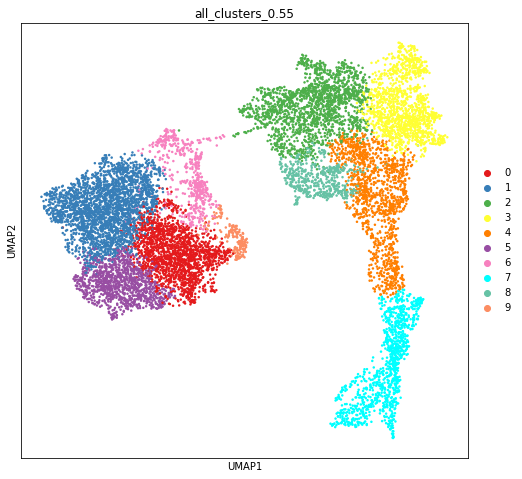

In [69]:
plt.rcParams["figure.figsize"] = (8,8)
identity = 'all_clusters_%s' % res
sc.pl.umap(ad_all, color=[identity], palette=palette1, size=25, add_outline=False)
plt.rcParams["figure.figsize"] = (5,5)

# Spatial plots

In [70]:
images = {id: sc.read(preprocessedStDataPath + '%s/st_adata_processed.h5ad' % id).uns['spatial'] for id in ids}

ads = dict()
for sample in ids[:]:
    ads[sample] = ad_all[ad_all.obs['sample']==sample, :].copy()    
    ads[sample].uns['spatial'] = images[sample]

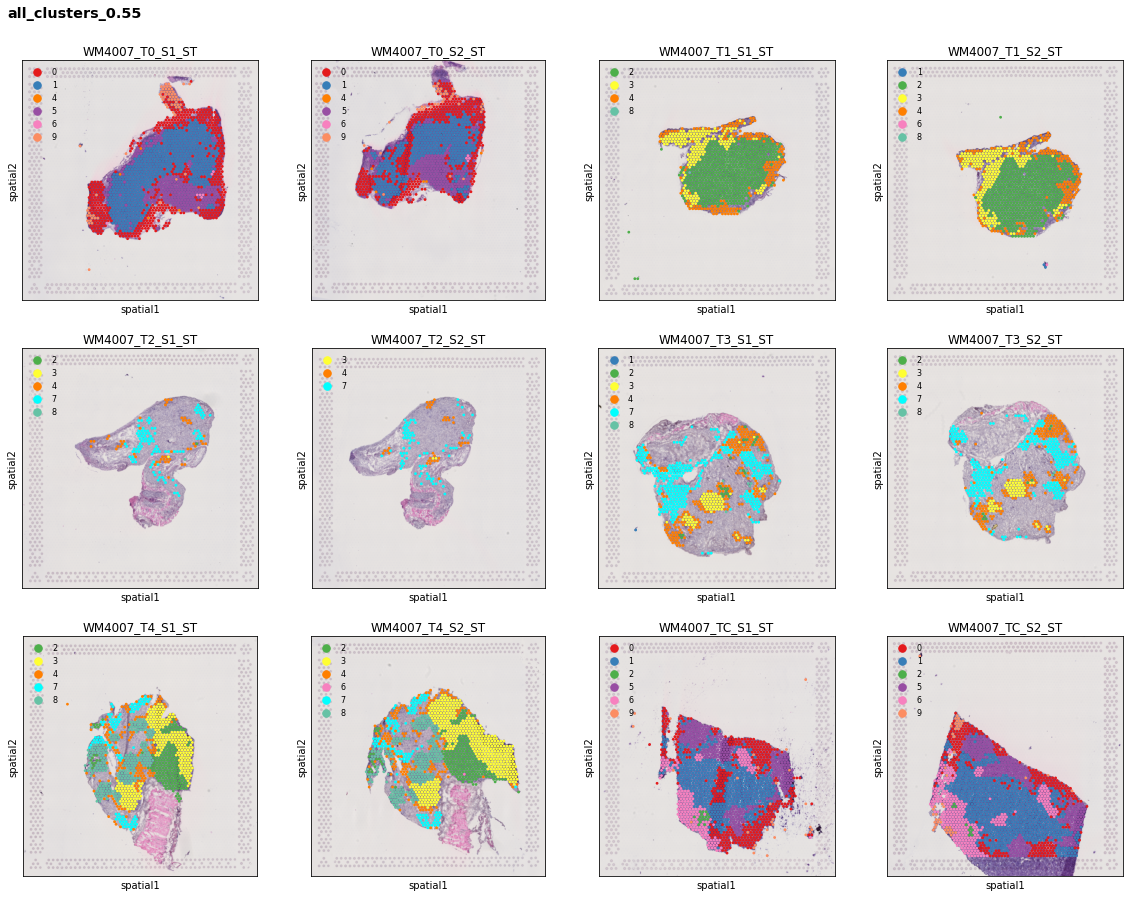

In [71]:
plotSpatialAll(ads, identity = 'all_clusters_%s' % res, palette=palette1, f=1.0)

# PHATE layout

In [72]:
ad_all.obsm['X_phate'] = phate.PHATE(n_jobs=4, n_pca=None).fit_transform(ad_all.obsm['X_pca_harmony'])
ad_all.uns['phate'] = dict(n_pca=None)

Calculating PHATE...
  Running PHATE on 11990 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 2.13 seconds.
    Calculating affinities...
    Calculated affinities in 0.10 seconds.
  Calculated graph and diffusion operator in 2.25 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.21 seconds.
    Calculating KMeans...
    Calculated KMeans in 12.18 seconds.
  Calculated landmark operator in 14.73 seconds.
  Calculating optimal t...
    Automatically selected t = 33
  Calculated optimal t in 5.14 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.47 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.13 seconds.
Calculated PHATE in 29.73 seconds.


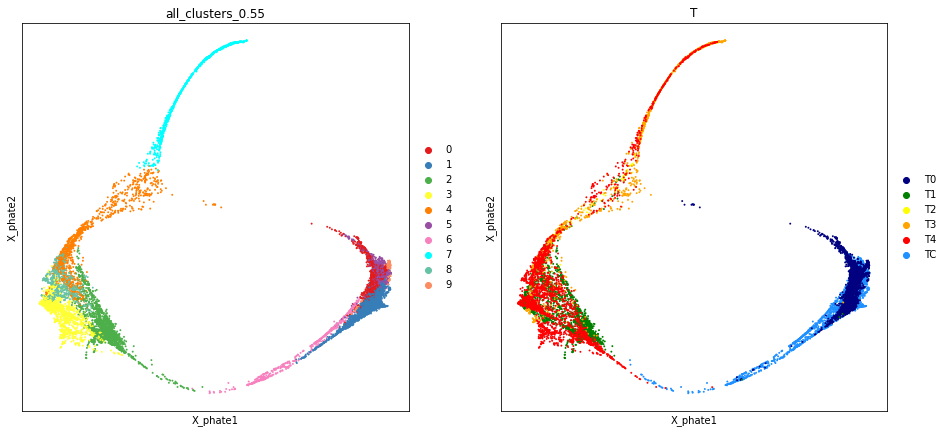

In [73]:
plt.rcParams["figure.figsize"] = (7, 7)
identity = 'all_clusters_%s' % res
sc.pl.embedding(ad_all, 'X_phate', color=[identity, 'T'], palette=palette1, size=15, add_outline=False)

# t-SNE layout

In [74]:
sc.tl.tsne(ad_all, n_pcs=None, use_rep='X_pca_harmony', random_state=0, use_fast_tsne=False, metric='euclidean')

C:\Users\domans\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


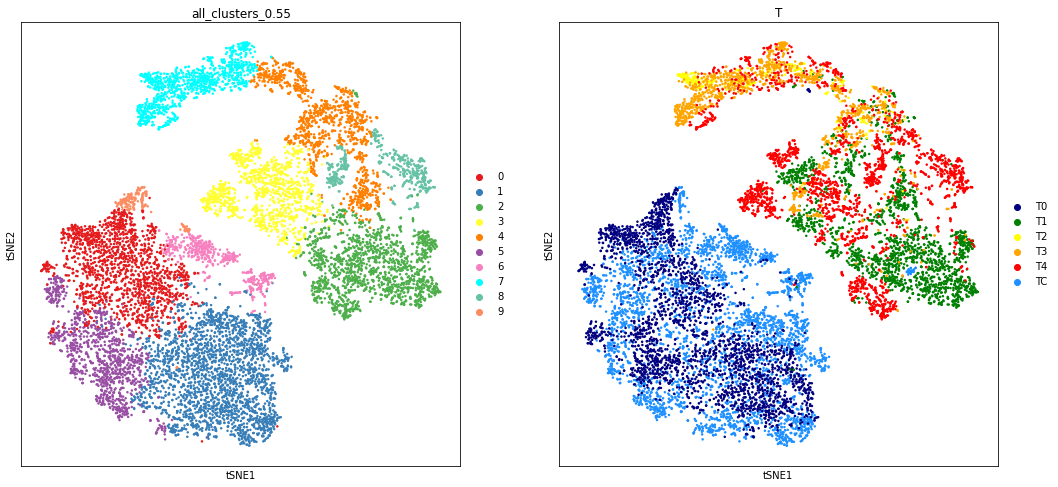

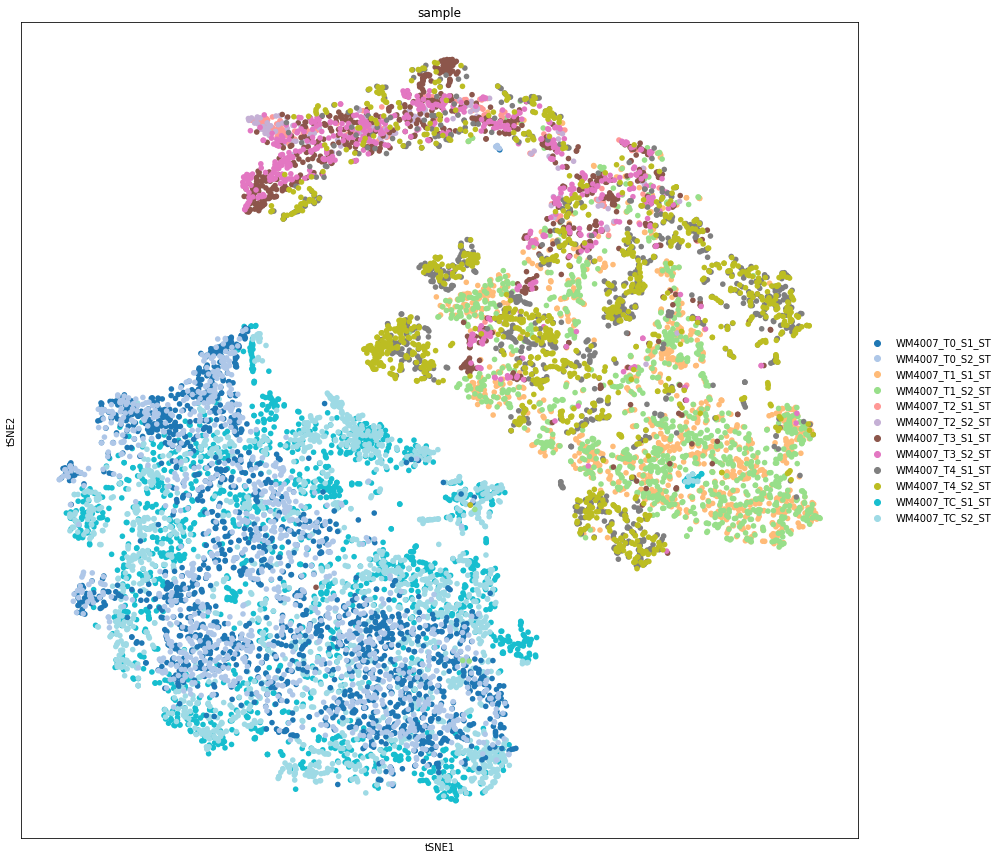

In [75]:
plt.rcParams["figure.figsize"] = (8,8)
identity = 'all_clusters_%s' % res
sc.pl.tsne(ad_all, color=[identity, 'T'], palette=palette1, size=25, add_outline=False)

plt.rcParams["figure.figsize"] = (15,15)
sc.pl.tsne(ad_all, color=['sample'], palette='tab20', size=125, add_outline=False)

# Save data object

In [6]:
ad_all.obs['cluster'] = ad_all.obs['all_clusters_0.55']
ad_all.write(dataPath + 'ad_all_human_clustered_st_%s.h5ad' % model)